In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
import scipy.io as sio
import random
import matplotlib.patches as patches
from PIL import Image
from scipy.io import loadmat
import tensorflow as tf
import cv2
import tarfile
import cv2 as cv
import shutil

In [2]:
base_dir1 = '/kaggle/input/cars-devkit'
annotations = sio.loadmat(os.path.join(base_dir1, 'cars_train_annos.mat'))

In [3]:
cars_meta = loadmat('/kaggle/input/cars-devkit/cars_meta.mat')

cars_train_annos = loadmat('/kaggle/input/cars-devkit/cars_train_annos.mat')
train_annotations = cars_train_annos['annotations'][0]

cars_test_annos = loadmat('/kaggle/input/cars-devkit/cars_test_annos_withlabels.mat')
test_annotations = cars_test_annos['annotations'][0]

class_names = cars_meta['class_names'][0]
num_classes = len(class_names)
print(f"Number of classes: {num_classes}")

Number of classes: 196


In [4]:
print(train_annotations)

[(array([[39]], dtype=uint8), array([[116]], dtype=uint8), array([[569]], dtype=uint16), array([[375]], dtype=uint16), array([[14]], dtype=uint8), array(['00001.jpg'], dtype='<U9'))
 (array([[36]], dtype=uint8), array([[116]], dtype=uint8), array([[868]], dtype=uint16), array([[587]], dtype=uint16), array([[3]], dtype=uint8), array(['00002.jpg'], dtype='<U9'))
 (array([[85]], dtype=uint8), array([[109]], dtype=uint8), array([[601]], dtype=uint16), array([[381]], dtype=uint16), array([[91]], dtype=uint8), array(['00003.jpg'], dtype='<U9'))
 ...
 (array([[26]], dtype=uint8), array([[246]], dtype=uint8), array([[660]], dtype=uint16), array([[449]], dtype=uint16), array([[163]], dtype=uint8), array(['08142.jpg'], dtype='<U9'))
 (array([[78]], dtype=uint8), array([[526]], dtype=uint16), array([[1489]], dtype=uint16), array([[908]], dtype=uint16), array([[112]], dtype=uint8), array(['08143.jpg'], dtype='<U9'))
 (array([[20]], dtype=uint8), array([[240]], dtype=uint8), array([[862]], dtype=ui

In [5]:
train_image_paths = [ann['fname'][0] for ann in train_annotations]  # Remove nested array structure
train_class_indices = [ann['class'][0][0] - 1 for ann in train_annotations]  # Extract class index
test_image_paths = [ann['fname'][0] for ann in test_annotations]
test_class_indices = [ann['class'][0][0] - 1 for ann in test_annotations]

In [6]:
!rm -rf /kaggle/working/*

In [7]:
def save_data(annotations, type='train'):
    for ann in annotations:
        index = ann['class'][0][0] - 1
        class_name = class_names[ann['class'][0][0] - 1]
        image_path = ann['fname'][0]
        x1 = ann['bbox_x1'][0][0]
        x2 = ann['bbox_x2'][0][0]
        y1 = ann['bbox_y1'][0][0]
        y2 = ann['bbox_y2'][0][0]
        if type == 'train':
            base_dir = '/kaggle/input/stanford-cars-dataset/cars_train/cars_train'
        else:
            base_dir = '/kaggle/input/stanford-cars-dataset/cars_test/cars_test'
            
        image_path = os.path.join(base_dir, image_path)
        image = cv.imread(image_path)
        height, width = image.shape[:2]
        margin = 16
    
        x1 = max(0, ann['bbox_x1'][0][0] - margin)
        x2 = min(ann['bbox_x2'][0][0] + margin, width)
        y1 = max(0, ann['bbox_y1'][0][0] - margin)
        y2 = min(ann['bbox_y2'][0][0] + margin, height)
    
        if type == 'train':
            dest_folder = '/kaggle/working/train/'
        else:
            dest_folder = '/kaggle/working/test/'
        dest_path = os.path.join(dest_folder, class_name[0])
        if not os.path.exists(dest_path):
            os.makedirs(dest_path)
        dest_path = os.path.join(dest_path, ann['fname'][0])
        crop_image = image[y1:y2, x1:x2]
        dest_img = cv.resize(src=crop_image, dsize=(224, 224))
        cv.imwrite(dest_path, dest_img)

save_data(train_annotations, type='train')
save_data(test_annotations, type='test')

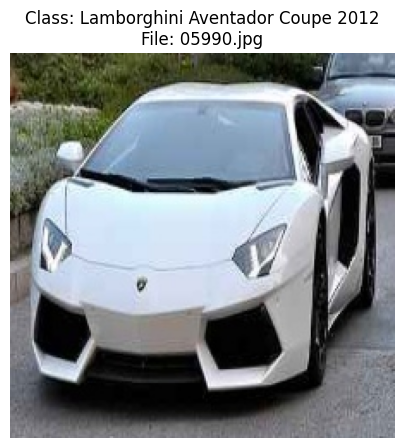

In [13]:
import matplotlib.pyplot as plt
import cv2 as cv
import os
import random

def show_processed_sample(dataset_type='train'):
    """Displays a random processed image along with its class label from the given dataset type ('train', 'validation', 'test')."""
    
    base_folder = f'/kaggle/working/{dataset_type}/'  # Folder where images are saved
    class_folders = [d for d in os.listdir(base_folder) if os.path.isdir(os.path.join(base_folder, d))]

    if not class_folders:
        print(f"No images found in {base_folder}")
        return
    
    # Choose a random class folder
    random_class = random.choice(class_folders)
    class_folder = os.path.join(base_folder, random_class)

    # Choose a random image from the selected class folder
    image_files = os.listdir(class_folder)
    if not image_files:
        print(f"No images found in {class_folder}")
        return

    random_image = random.choice(image_files)
    image_path = os.path.join(class_folder, random_image)

    # Load and display the image
    image = cv.imread(image_path)
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)  

    plt.figure(figsize=(5, 5))
    plt.imshow(image)
    plt.title(f"Class: {random_class}\nFile: {random_image}")  # Show class label in title
    plt.axis("off")
    plt.show()

# Call function to show a sample from the training dataset
show_processed_sample('train')

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import os
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Convolution2D,MaxPooling2D,Flatten #action detectionimport tensorflow
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import HTML

In [13]:
import os
import torch
import random
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split

# Define transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Load dataset
data_dir = '/kaggle/working'
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=data_transforms['train'])
test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=data_transforms['test'])

# Get all indices and corresponding labels
train_indices = list(range(len(train_dataset)))
train_labels = [train_dataset.targets[i] for i in train_indices]  # Get labels

# Perform stratified split (80% train, 20% validation)
train_idx, val_idx = train_test_split(train_indices, test_size=0.2, stratify=train_labels, random_state=42)

# Create subset datasets
train_subset = Subset(train_dataset, train_idx)
val_subset = Subset(train_dataset, val_idx)

# Create DataLoaders
batch_size = 32
dataloaders = {
    'train': DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=4),
    'val': DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=4),
    'test': DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
}

dataset_sizes = {
    'train': len(train_subset),
    'val': len(val_subset),
    'test': len(test_dataset)
}

class_names = train_dataset.classes  # Get class names

print(f"Train Size: {dataset_sizes['train']}, Validation Size: {dataset_sizes['val']}, Test Size: {dataset_sizes['test']}")
print(f"Class Names: {class_names}")


Train Size: 6515, Validation Size: 1629, Test Size: 8041
Class Names: ['AM General Hummer SUV 2000', 'Acura Integra Type R 2001', 'Acura RL Sedan 2012', 'Acura TL Sedan 2012', 'Acura TL Type-S 2008', 'Acura TSX Sedan 2012', 'Acura ZDX Hatchback 2012', 'Aston Martin V8 Vantage Convertible 2012', 'Aston Martin V8 Vantage Coupe 2012', 'Aston Martin Virage Convertible 2012', 'Aston Martin Virage Coupe 2012', 'Audi 100 Sedan 1994', 'Audi 100 Wagon 1994', 'Audi A5 Coupe 2012', 'Audi R8 Coupe 2012', 'Audi RS 4 Convertible 2008', 'Audi S4 Sedan 2007', 'Audi S4 Sedan 2012', 'Audi S5 Convertible 2012', 'Audi S5 Coupe 2012', 'Audi S6 Sedan 2011', 'Audi TT Hatchback 2011', 'Audi TT RS Coupe 2012', 'Audi TTS Coupe 2012', 'Audi V8 Sedan 1994', 'BMW 1 Series Convertible 2012', 'BMW 1 Series Coupe 2012', 'BMW 3 Series Sedan 2012', 'BMW 3 Series Wagon 2012', 'BMW 6 Series Convertible 2007', 'BMW ActiveHybrid 5 Sedan 2012', 'BMW M3 Coupe 2012', 'BMW M5 Sedan 2010', 'BMW M6 Convertible 2010', 'BMW X3 SUV

In [25]:
# Load a pre-trained ResNet model
model = models.resnet50(pretrained=True)

# Modify the final layer to match the number of classes
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 196)

# Move the model to the GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [26]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [27]:
import matplotlib.pyplot as plt

def train_model(model, criterion, optimizer, num_epochs=25):
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Training mode
            else:
                model.eval()   # Evaluation mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Store loss & accuracy
            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.item())
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc.item())

    return model, history  # Return history for plotting

# Train the model and get history
model, history = train_model(model, criterion, optimizer, num_epochs=25)


Epoch 0/24
----------
train Loss: 5.2201 Acc: 0.0180
val Loss: 5.0117 Acc: 0.0430
Epoch 1/24
----------
train Loss: 4.7801 Acc: 0.0801
val Loss: 4.4724 Acc: 0.1314
Epoch 2/24
----------
train Loss: 4.2335 Acc: 0.1679
val Loss: 3.9522 Acc: 0.1780
Epoch 3/24
----------
train Loss: 3.6852 Acc: 0.2606
val Loss: 3.4288 Acc: 0.2953
Epoch 4/24
----------
train Loss: 3.2143 Acc: 0.3477
val Loss: 2.9886 Acc: 0.3665
Epoch 5/24
----------
train Loss: 2.7660 Acc: 0.4293
val Loss: 2.5846 Acc: 0.4481
Epoch 6/24
----------
train Loss: 2.4068 Acc: 0.5173
val Loss: 2.3025 Acc: 0.4972
Epoch 7/24
----------
train Loss: 2.1129 Acc: 0.5698
val Loss: 2.0069 Acc: 0.5476
Epoch 8/24
----------
train Loss: 1.8763 Acc: 0.6226
val Loss: 1.8303 Acc: 0.5955
Epoch 9/24
----------
train Loss: 1.6450 Acc: 0.6591
val Loss: 1.6924 Acc: 0.6329
Epoch 10/24
----------
train Loss: 1.4690 Acc: 0.6912
val Loss: 1.5341 Acc: 0.6440
Epoch 11/24
----------
train Loss: 1.3214 Acc: 0.7263
val Loss: 1.3902 Acc: 0.6587
Epoch 12/24
--

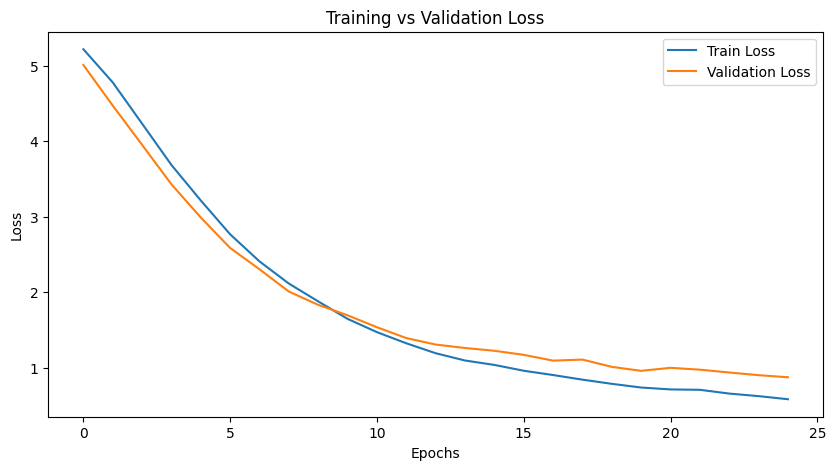

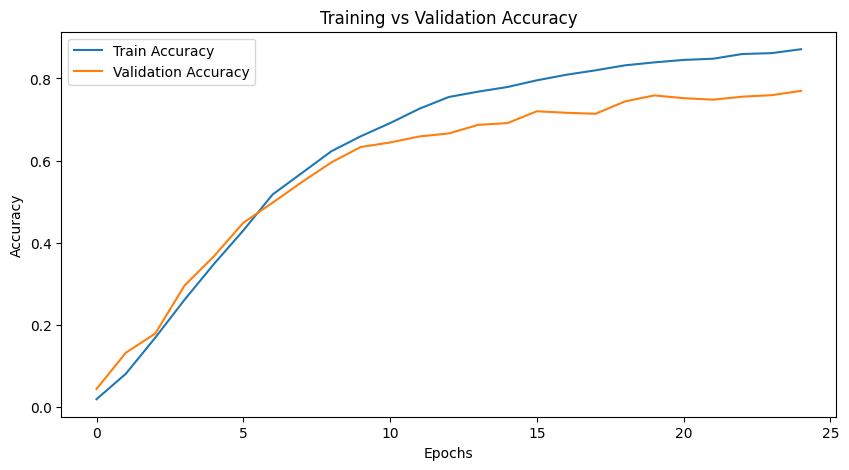

In [28]:
# Plot Loss Curve
plt.figure(figsize=(10, 5))
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()

# Plot Accuracy Curve
plt.figure(figsize=(10, 5))
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.show()


In [29]:
torch.save(model.state_dict(), 'car_model.pth')

In [30]:
def evaluate_model(model, dataloader):
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    accuracy = accuracy_score(all_labels, all_preds)

    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1-Score: {f1:.4f}')
    print(f'Accuracy: {accuracy:.4f}')

# Evaluate on the test dataset
print("Evaluating on the test dataset...")
evaluate_model(model, dataloaders['test'])

Evaluating on the test dataset...
Precision: 0.8670
Recall: 0.8615
F1-Score: 0.8608
Accuracy: 0.8615


In [31]:
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Function to classify categories
def classify_category(car_class):
    car_class_lower = car_class.lower()  # Convert to lowercase for easier matching

    if any(keyword in car_class_lower for keyword in ["truck", "pickup"]):
        return "Truck"
    elif any(keyword in car_class_lower for keyword in ["suv"]):
        return "SUV"
    elif any(keyword in car_class_lower for keyword in ["sedan"]):
        return "Sedan"
    elif any(keyword in car_class_lower for keyword in ["coupe", "convertible", "911", "corvette"]):
        return "Sports Car"
    elif any(keyword in car_class_lower for keyword in ["tesla"]):
        return "Electric"
    else:
        return "Others"  # Default category for unclassified cars

# Map each class to its category
category_map = {i: classify_category(class_names[i]) for i in range(len(class_names))}

# Get unique categories
unique_categories = list(set(category_map.values()))

In [32]:
def evaluate_model_with_roc(model, dataloader, category_map, unique_categories):
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)  # Get probabilities
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    # Convert to numpy arrays
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)

    # Binarize the labels for each category
    binarized_labels = {}
    binarized_probs = {}

    for category in unique_categories:
        # Get indices of classes belonging to this category
        category_indices = [i for i, cat in category_map.items() if cat == category]
        # Binarize labels for this category
        binarized_labels[category] = np.isin(all_labels, category_indices).astype(int)
        # Sum probabilities for this category
        binarized_probs[category] = np.sum(all_probs[:, category_indices], axis=1)

    return binarized_labels, binarized_probs, all_labels, all_preds

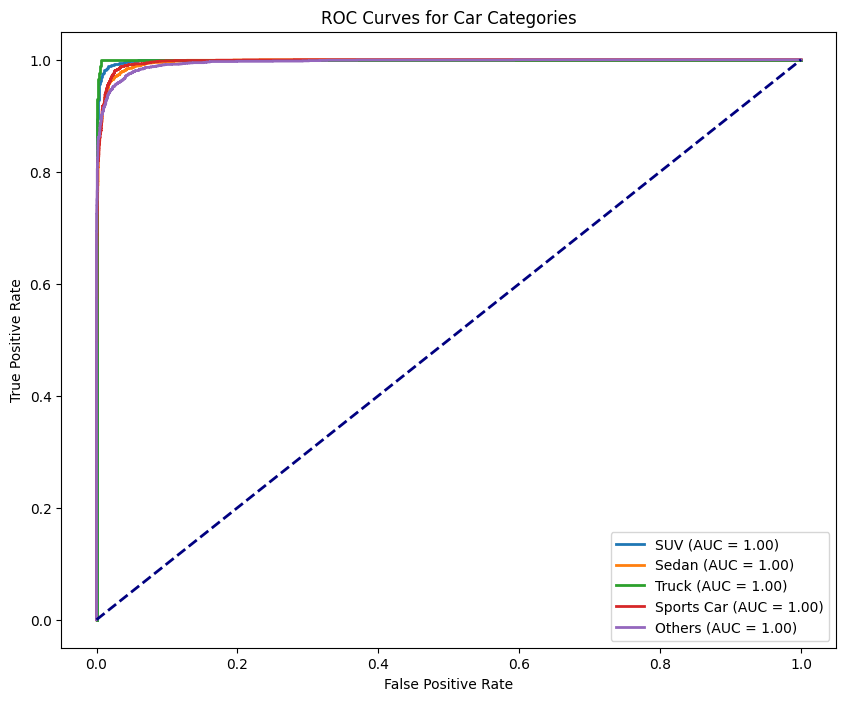

In [33]:
def plot_roc_curves(binarized_labels, binarized_probs, unique_categories):
    plt.figure(figsize=(10, 8))

    for category in unique_categories:
        fpr, tpr, _ = roc_curve(binarized_labels[category], binarized_probs[category])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'{category} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for Car Categories')
    plt.legend(loc="lower right")
    plt.show()

# Evaluate the model and get ROC data
binarized_labels, binarized_probs, all_labels, all_preds = evaluate_model_with_roc(model, dataloaders['test'], category_map, unique_categories)

# Plot ROC curves
plot_roc_curves(binarized_labels, binarized_probs, unique_categories)